In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')



## Feature extraction

In [7]:
from sqlalchemy import create_engine
import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
# days_worked_data = pd.read_sql(days_worked_query,conn)
# print(datetime.now())
# apps_done_data = pd.read_sql(apps_done_query,conn)
# print(datetime.now())
# logs_done_data = pd.read_sql(logs_done_query,conn)
# print(datetime.now())
# print(datetime.now())
# texts_received_data = pd.read_sql(texts_received_query, conn)
# print(datetime.now())
# login_events_data = pd.read_sql(logins_events_query, conn)
# print(datetime.now())
# views_done_data = pd.read_sql(views_done_query, conn)
# print(datetime.now())
# pvs_data = pd.read_sql(pvs_query, conn)
# print(datetime.now())
# md_data = pd.read_sql(md_query, conn)
# print(datetime.now())
# customer_pop_data = pd.read_sql(customer_popularity_query,conn)
# print(datetime.now())
#
# customer_pop_data.to_csv('../data/customer_popularity_data.csv', index = False)
# md_data.to_csv('../data/md_data.csv', index = False)#
# pvs_data.to_csv('../data/pvs_data.csv', index = False)
# views_done_data.to_csv('../data/views_done_data.csv', index = False)
# login_events_data.to_csv('../data/login_events_data.csv', index = False)
# days_worked_data.to_csv('../data/days_worked_data.csv', index = False)
# logs_done_data.to_csv('../data/logs_done_data.csv', index = False)
# apps_done_data.to_csv('../data/apps_done_data.csv', index = False)
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)
# texts_received_data.to_csv('../data/texts_received_data.csv', index = False)


## Feature engineering

In [230]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')
days_worked_data = pd.read_csv('../data/days_worked_data.csv')
apps_done_data = pd.read_csv('../data/apps_done_data.csv')
logs_done_data = pd.read_csv('../data/logs_done_data.csv')
texts_received_data = pd.read_csv('../data/texts_received_data.csv')
# logins_events_data = pd.read_csv('../data/login_events_data.csv')
views_done_data = pd.read_csv('../data/views_done_data.csv')
pvs_data = pd.read_csv('../data/pvs_data.csv')
md_data = pd.read_csv('../data/md_data.csv')
customer_pop_data = pd.read_csv('../data/customer_popularity_data.csv')

In [234]:
customer_pop_data['date'] = customer_pop_data.date.apply(lambda x:str(x))
days_worked_data['date'] = days_worked_data.date.apply(lambda x:str(x))
logs_done_data['date'] = logs_done_data.date.apply(lambda x:str(x))
texts_received_data['date'] = texts_received_data.date.apply(lambda x:str(x))
apps_done_data['date'] = apps_done_data.date.apply(lambda x:str(x))
views_done_data['date'] = views_done_data.date.apply(lambda x:str(x))
pvs_data['sent_at'] = pvs_data['sent_at'].apply(lambda x:str(x))
md_data['sent_at'] = md_data['sent_at'].apply(lambda x:str(x))

training_data['date_sent_at'] = pd.to_datetime(training_data['sent_at'],format='%Y-%m-%d').dt.date.apply(lambda x:str(x))

print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(days_worked_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(apps_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(logs_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(texts_received_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(views_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(pvs_data, how='left', left_on = ['sent_at','carer_id'],
                          right_on = ['sent_at','carer_id'])
print(all_data.shape)
all_data = all_data.merge(md_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(customer_pop_data, how='left',left_on = ['date_sent_at','customer_id'],
                          right_on = ['date','customer_id'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)


target = 'carer_applied_in_8hrs'

(2246563, 38)
(2246563, 39)
(2246563, 69)
(2246563, 70)
(2246563, 73)
(2246563, 75)
(2246563, 77)
(2246563, 75)
(2246563, 77)
(2246563, 79)
(2246563, 81)
(2246563, 82)
(2246563, 83)


KeyError: 'customer_id'

In [185]:
print(f'There are {all_data[target].sum()} applications for {all_data.placement_ad_id.nunique()} placement ads')

There are 17072 applications for 15000 placement ads


In [186]:
all_data.groupby('sms_type')[target].sum()/all_data.groupby('sms_type')[target].count()* 100

sms_type
customListSent            0.647119
initialPromotionSent      2.011581
preferredPlacementSent    1.707971
returningCarerSent        0.810026
slowMatchingSent          1.163568
urgentMatchSent           0.780866
Name: carer_applied_in_8hrs, dtype: float64

In [187]:
all_data.avg_popularity_score.isna().sum()

786356

### Data preparation

In [210]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[(all_data['carer_applied_in_8hrs']==0)].sample(frac=0.01, random_state=1992)
#&(all_data.avg_popularity_score.notnull())
df = pd.concat([X1,X0], axis = 0)
df

,placement_ad_id,match_request_id,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,days_worked_past_90,apps_past_7_days,date_x,login_past_7_days,date_y,texts_past_30_days,date,viewed_placements_past_7_days,predicted_value,difficulty_normalised
19,plad_pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9...,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,p100093502,2021-08-17 11:29:26,2021-08-17 11:28:26,initialPromotionSent,1,34,1,700.0,...,7.0,3.0,2021-08-17,43.0,2021-08-17,83.0,2021-08-17,5.0,NaN,NaN
27,plad_pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a...,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,p100139148,2019-12-30 11:44:46,2019-12-30 11:36:45,initialPromotionSent,1,7,0,550.0,...,25.0,21.0,2019-12-30,45.0,2019-12-30,53.0,NaN,NaN,NaN,0.568004
82,plad_pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8...,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,p100139148,2020-02-07 16:44:36,2020-02-07 16:36:02,initialPromotionSent,1,4,1,550.0,...,29.0,NaN,2020-02-07,15.0,2020-02-07,97.0,NaN,NaN,NaN,1.604750
149,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,600.0,...,NaN,NaN,NaN,NaN,2021-07-02,100.0,NaN,NaN,139.8040,1.705170
430,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,650.0,...,NaN,1.0,2020-08-17,17.0,2020-08-17,23.0,NaN,NaN,84.1962,1.270840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070203,plad_pl_s0vplcUSs5VL_0kcu-7ea949b9-4a76-496c-a...,pl_s0vplcUSs5VL_0kcu-7ea949b9-4a76-496c-acd7-6...,p218278926,2021-02-17 10:37:00,2021-02-16 21:45:37,customListSent,0,9,1,700.0,...,NaN,1.0,2021-02-17,5.0,2021-02-17,133.0,NaN,NaN,133.2950,2.003010
499221,plad_pl_s05aclAG8Izo_nLJ1-5fac27ce-74be-4ac2-9...,pl_s05aclAG8Izo_nLJ1-5fac27ce-74be-4ac2-9adf-2...,p75982522,2021-05-12 11:43:07,2021-05-10 11:36:22,slowMatchingSent,0,5,1,560.0,...,NaN,NaN,NaN,NaN,2021-05-12,25.0,NaN,NaN,49.8368,1.581130
928670,plad_pl_s00EmWw0IiYV_dV40-022ab20b-5f94-4aa9-a...,pl_s00EmWw0IiYV_dV40-022ab20b-5f94-4aa9-abfc-4...,p185039456,2021-06-08 11:22:00,2021-06-07 16:06:03,customListSent,0,3,0,600.0,...,NaN,NaN,2021-06-08,1.0,2021-06-08,23.0,NaN,NaN,NaN,1.730600
1411669,plad_pl_s0GiWlBEratg_tbtg-0e1d4909-020c-4520-a...,pl_s0GiWlBEratg_tbtg-0e1d4909-020c-4520-a234-7...,p122411871,2021-03-01 10:44:00,2021-03-01 10:16:00,customListSent,0,2,0,590.0,...,24.0,NaN,2021-03-01,10.0,2021-03-01,73.0,NaN,NaN,184.1210,0.680598


In [211]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [212]:
df = df.loc[df.lead_time>0]
df['texts_past_30_days'].replace(np.nan,0,inplace = True)
df['login_past_7_days'].replace(np.nan,0,inplace = True)
df['apps_past_7_days'].replace(np.nan,0,inplace = True)
df['days_worked_past_90'].replace(np.nan,0,inplace = True)
df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)
df['viewed_placements_past_7_days'].replace(np.nan,0,inplace = True)


df = pd.get_dummies(df,columns=['sms_type'],drop_first=True)

df['max_cr_age']= df['max_cr_age'].clip(18,118)

df['log_lead_time'] = np.log(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['exp_lead_time'] = np.exp(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['log_lead_time'] = df.log_lead_time.clip(0)

#carer likes X and X is there
df['met_licence'] = df['has_licence'] * df['licence_needed']
df['met_car'] = df['has_car'] * df['car_needed']

df['met_moving_handling'] = df['moving_handling'] * df['carer_moving_handling']
df['met_stoma'] = df['stoma'] * df['carer_stoma']
df['met_dementia'] = df['dementia'] * df['carer_dementia']
df['met_alzheimers'] = df['alzheimers'] * df['carer_alzheimers']
df['met_parkinsons'] = df['parkinsons'] * df['carer_parkinsons']
df['met_stroke'] = df['stroke'] * df['carer_stroke']
df['met_diabetes'] = df['diabetes'] * df['carer_diabetes']
df['met_peg'] = df['peg'] * df['carer_peg']
df['met_hoist'] = df['hoist'] * df['carer_hoist']
df['met_mental_health_issue'] = df['mental_health_issues'] * df['carer_mental_health_issues']

df['met_distance_50'] = np.where((df['maxDistance_50']==1) & (df['distance_km']*1.61 <= 50),1,0 )
df['met_distance_100'] = np.where((df['maxDistance_100']==1) & (df['distance_km']*1.61 <= 100),1,0 )
df['met_distance_400'] = np.where((df['maxDistance_400']==1) & (df['distance_km']*1.61 <= 400),1,0 )

#carer doesn't like X and X is not there
df['met_smoking'] = np.where((df['smoking'] == 0 )& (df['smokingClientsExclusion'] ==1),1,0)
df['met_dogs'] = np.where((df['has_dogs'] == 0) & (df['petsExclusion_DOGS'] ==1),1,0)
df['met_cats'] = np.where((df['has_cats'] == 0 )& (df['petsExclusion_CATS'] ==1),1,0)
df['met_2crs'] = np.where((df['has_two_crs'] == 0) & (df['recipientNumberExclusion_2CRs'] ==1),1,0)
df['met_cr_gender'] = np.where((df['recipient_1_male'] == 0) & (df['genderExclusion_MALE'] ==1),1,0)


df['met_ear_WHITE_ALL'] = np.where((df['ethnicities_at_risk_WHITE_ALL'] ==0) & (df['ethnicityExclusion_WHITE_ALL'] ==1),1,0)
df['met_ear_MIXED_ALL'] = np.where((df['ethnicities_at_risk_MIXED_ALL'] ==0) & (df['ethnicityExclusion_MIXED_ALL'] ==1),1,0)
df['met_ear_BLACK_ALL'] = np.where((df['ethnicities_at_risk_BLACK_ALL'] ==0) & (df['ethnicityExclusion_BLACK_ALL'] ==1),1,0)
df['met_ear_ASIAN_ALL'] = np.where((df['ethnicities_at_risk_ASIAN_ALL'] ==0) & (df['ethnicityExclusion_ASIAN_ALL'] ==1),1,0)
df['met_ear_ARAB_ALL'] = np.where((df['ethnicities_at_risk_ARAB_ALL'] ==0) & (df['ethnicityExclusion_ARAB_ALL'] ==1),1,0)

#carer doesn't like X but X is there
df['broken_ear_WHITE_ALL'] = df['ethnicities_at_risk_WHITE_ALL'] * df['ethnicityExclusion_WHITE_ALL']
df['broken_ear_MIXED_ALL'] = df['ethnicities_at_risk_MIXED_ALL']* df['ethnicityExclusion_MIXED_ALL']
df['broken_ear_BLACK_ALL'] = df['ethnicities_at_risk_BLACK_ALL'] * df['ethnicityExclusion_BLACK_ALL']
df['broken_ear_ASIAN_ALL'] = df['ethnicities_at_risk_ASIAN_ALL'] * df['ethnicityExclusion_ASIAN_ALL']
df['broken_ear_ARAB_ALL'] = df['ethnicityExclusion_ARAB_ALL'] * df['ethnicityExclusion_ARAB_ALL']


## count of soft preferences that are met
df['count_soft_preferences'] = df['met_distance_50'] +  df['met_distance_100'] + df['met_distance_400'] + \
                               df['met_smoking'] + df['met_dogs'] + df['met_cats'] + df['met_2crs'] + \
                               df['met_cr_gender'] + df['met_ear_WHITE_ALL']  + df['met_ear_MIXED_ALL']  + \
                               df['met_ear_BLACK_ALL']  + df['met_ear_ASIAN_ALL'] +df['met_ear_ARAB_ALL']

In [213]:
## interactions of "every" feature with the top three

adj_predictors = predictors
[adj_predictors.remove(x) for x in ['placement_ad_id','apps_past_7_days',
                                    'days_worked_past_90','distance_km','sms_type'] if x in adj_predictors]

for p in adj_predictors:
    # print(p)
    df[f'days_worked_{p}'] = df['days_worked_past_90'] * df[p]
    df[f'apps_past_{p}'] = df['apps_past_7_days'] * df[p]
    df[f'distance_{p}'] = df['distance_km'] * df[p]



In [214]:
df['grouped_days_worked_past_90'] = np.where(df['days_worked_past_90'] == 0,0,np.nan)
df.loc[(df['days_worked_past_90']>0) & (df['days_worked_past_90']<=45) ,'grouped_days_worked_past_90'] = 1
df.loc[(df['days_worked_past_90']>45),'grouped_days_worked_past_90'] = 2
df['grouped_days_worked_past_90'].value_counts()

0.0    14234
1.0     8674
2.0     4103
Name: grouped_days_worked_past_90, dtype: int64

In [215]:
df['grouped_apps_past_7_days'] = np.where(df['apps_past_7_days'] == 0,0,np.nan)
df.loc[(df['apps_past_7_days']>0) & (df['apps_past_7_days']<8) ,'grouped_apps_past_7_days'] = 1
df.loc[(df['apps_past_7_days']>7),'grouped_apps_past_7_days'] = 2
df['grouped_apps_past_7_days'].value_counts()

0.0    13810
1.0     9156
2.0     4045
Name: grouped_apps_past_7_days, dtype: int64

## Feature selection

In [216]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [217]:
for p in predictors:
    if df[p].isna().sum()>0:
        print(p,df[p].isna().sum())

print(df.shape)
df = df.loc[df[predictors].notnull().all(axis=1)]
print(df.shape)

max_cr_age 290
avg_popularity_score 8366
ethnicityExclusion_ARAB_ALL 220
ethnicityExclusion_ASIAN_ALL 220
ethnicityExclusion_BLACK_ALL 220
ethnicityExclusion_MIXED_ALL 220
ethnicityExclusion_WHITE_ALL 220
genderExclusion_MALE 220
maxDistance_50 220
maxDistance_100 220
maxDistance_400 220
petsExclusion_CATS 220
petsExclusion_DOGS 220
recipientNumberExclusion_2CRs 220
smokingClientsExclusion 220
has_licence 220
has_car 220
carer_moving_handling 220
carer_dementia 220
carer_mental_health_issues 220
carer_hoist 220
carer_parkinsons 220
carer_stroke 220
carer_alzheimers 220
carer_stoma 220
carer_diabetes 220
carer_peg 220
carer_age 261
log_career_years_of_experience 748
log_years_on_elder 479
carer_gender_FEMALE 220
distance_km 113
difficulty_normalised 69
met_licence 220
met_car 220
met_moving_handling 220
met_stoma 220
met_dementia 220
met_alzheimers 220
met_parkinsons 220
met_stroke 220
met_diabetes 220
met_peg 220
met_hoist 220
met_mental_health_issue 220
broken_ear_WHITE_ALL 220
broken

In [308]:
# X_train, X_eval, y_train, y_eval = split_train_test(df.sort_values('placement_ad_id'),predictors,target,shuffle = False, test_size=0.25)
#
# print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
# print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')
#
# X_train.drop('placement_ad_id', axis = 1, inplace= True)
# X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 9602 placements in the training set with 11930 applications
There are 3290 placements in the eval set with 4137 applications


In [218]:
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target,test_size=0.25)

print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')

X_train.drop('placement_ad_id', axis = 1, inplace= True)
X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 4986 placements in the training set with 5601 applications
There are 2809 placements in the eval set with 1900 applications


In [219]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [ ]:
n_features =6
X = X_train
y = np.ravel(y_train)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

recall_scorer = make_scorer(recall_score, greater_is_better=True)
precision_scorer = make_scorer(precision_score, greater_is_better=True) #gets zero positive examples in some folds

results = select_features(rf, n_features, y, X,scoring=recall_scorer)

Running for 1 features


In [25]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

NameError: name 'results' is not defined

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

array([1, 2, 0])

In [220]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
    'carer_gender_FEMALE','log_lead_time','distance_km',
    'has_dogs','log_years_on_elder', 'max_cr_age',
     'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male','avg_popularity_score']

model.fit(X_train[f_predictors], np.ravel(y_train))


preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'TRAIN Recall is {round(recall_score(y_train,model.predict(X_train[f_predictors])),5)}, accuracy is {round(accuracy_score(y_train,model.predict(X_train[f_predictors])),5)}, precision is {round(precision_score(y_train,model.predict(X_train[f_predictors])),5)}')

print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')
#Recall is 0.79298, accuracy is 0.82878, precision is 0.83292 grouped
#Recall is 0.7327, accuracy is 0.80905, precision is 0.83863 continuous
#Recall is 0.68021, accuracy is 0.78553, precision is 0.82987 cluster

TRAIN Recall is 0.7529, accuracy is 0.83323, precision is 0.83687
EVAL Recall is 0.74947, accuracy is 0.82676, precision is 0.83178


In [ ]:
pred_probs = model.predict_proba(X_eval)

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

pred_proba_df = pd.DataFrame(pred_probs)
for i in np.arange(0.0, 1.0, 0.05):
    print (f'\n for i = {i} ')
    y_test_pred = pred_proba_df[1].apply(lambda x: 1 if x>i else 0)

    print(f'Eval accuracy is {accuracy_score(y_eval,y_test_pred)}')
    print(f'Eval precision is {precision_score(y_eval,y_test_pred)}')
    print(f'Eval recall is {recall_score(y_eval,y_test_pred)}')

    if (i==0.05) | (round(i,2)==0.95):
        print(confusion_matrix(y_eval,y_test_pred))


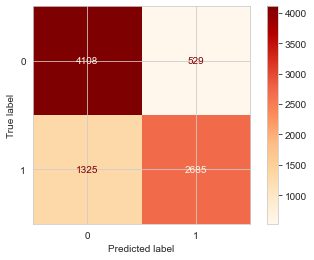

In [595]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')

Dropped 4766 missing observations


ValueError: Could not interpret value `grouped_days_worked_past_90` for parameter `x`

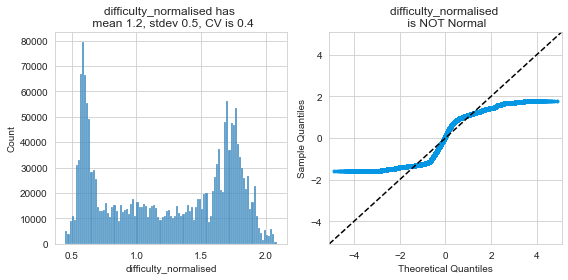

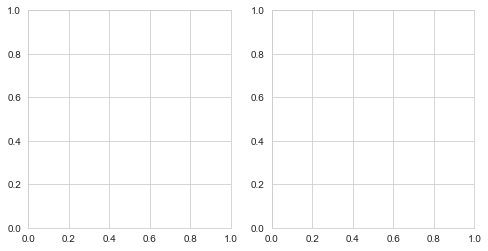

In [222]:
for f in f_predictors:
    plot_histogram(f, all_data)

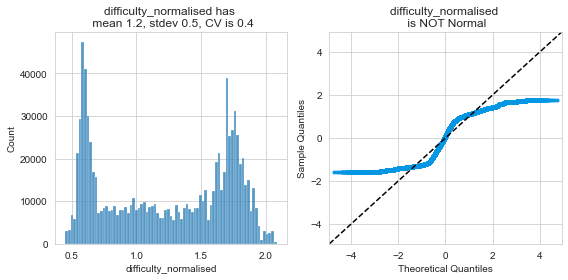

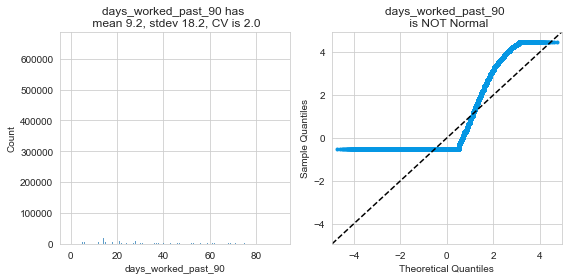

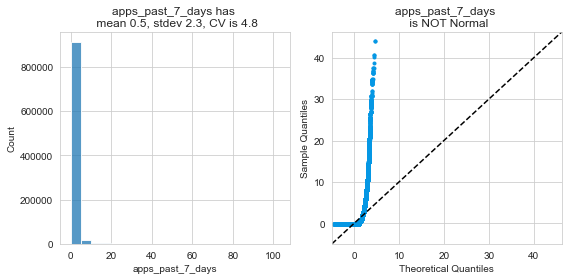

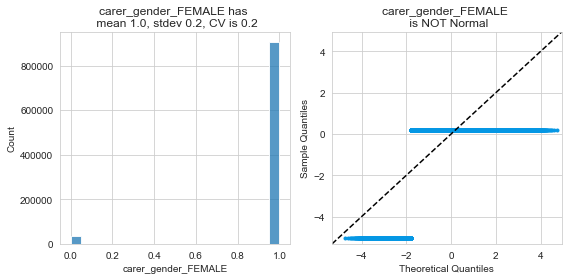

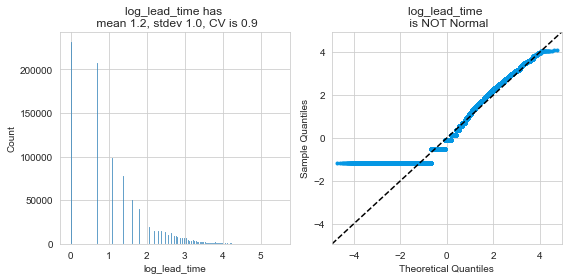

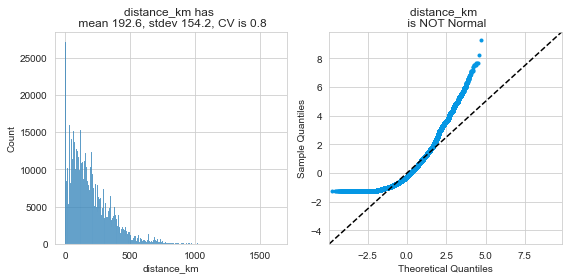

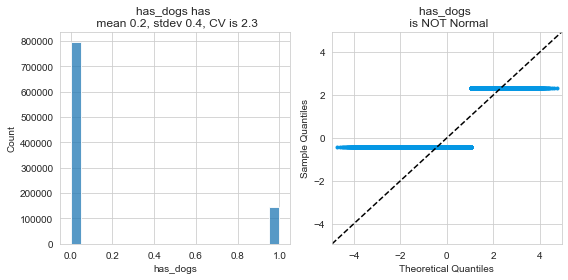

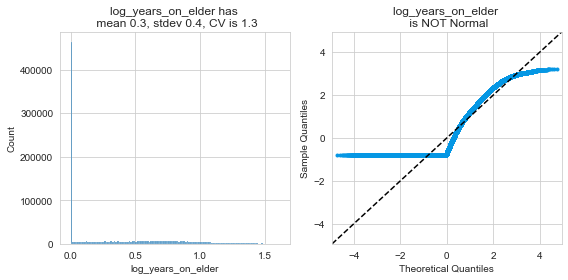

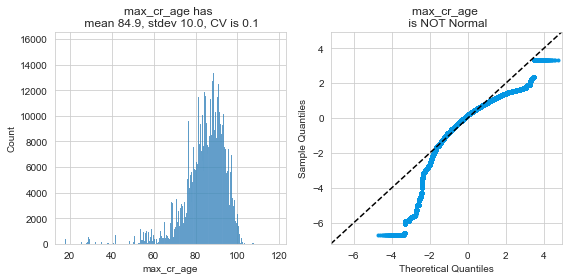

In [478]:
for f in f_predictors:
    plot_histogram(f, df)



We care more about recall than precision for two reasons:

 - conversion apps/messages is less important than apps/placements
 - reaching relevant carers could increase apps/placements and carer 'engagement'

On a balanced sample (around 50% each applied/not applied), the model
['predicted_value','days_worked_past_90','apps_past_7_days','carer_gender_FEMALE'] does a fair job at classifying positive examples
correctly, showing an accuracy of 77.7% together with i) a recall score of 62.7%
and ii) a precision of 81% on the evaluation set (not used for FS)



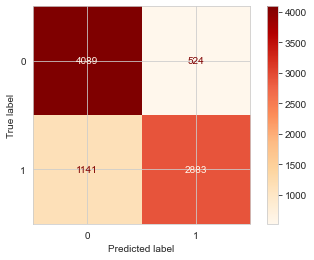

In [509]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')


  0%|          | 0/1000 [00:00<?, ?it/s]

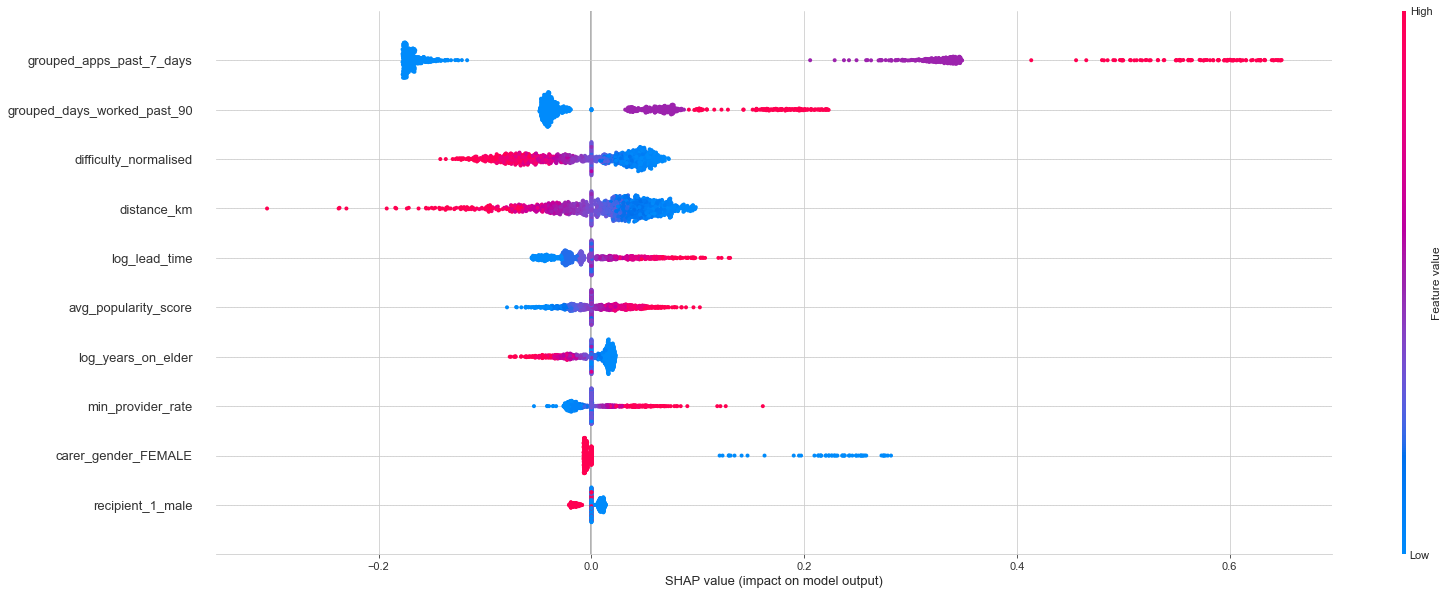

In [221]:
import warnings
warnings.filterwarnings('ignore')


scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

masker = shap.maskers.Impute(data=scaler.transform(X_train[f_predictors]), )

model = LogisticRegression()
model.fit(X_eval[f_predictors],np.ravel(y_eval))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1] #only returning probability of class 1

explainer = shap.KernelExplainer(model_predict_proba, X_train[f_predictors][:50], masker=masker)
shap_values = explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=10, show=False, plot_size=None )


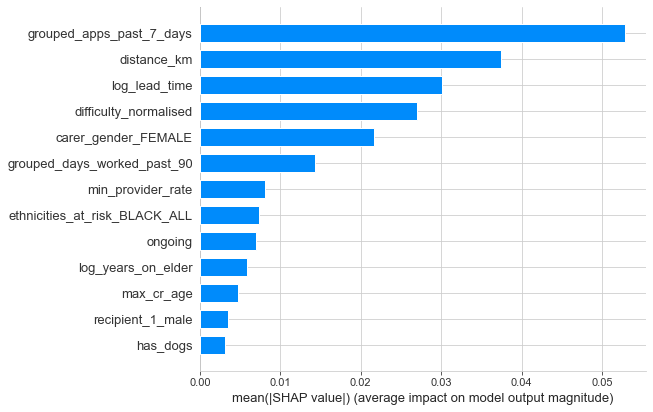

In [27]:
shap.summary_plot(shap_values, features=X_eval[f_predictors][:1000], feature_names=X_eval[f_predictors].columns, plot_type='bar')

## Testing tree-based models

#### Random forest

In [168]:

rf = RandomForestClassifier()
rf.fit(X_train[f_predictors], np.ravel(y_train))


preds = rf.predict(X_eval[f_predictors])

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')


Recall is 0.80682, accuracy is 0.82862, precision is 0.82277


In [ ]:
importances = rf.feature_importances_
# importances[::-1].sort()
forest_importances = pd.DataFrame(importances, index=X_train[f_predictors].columns)
forest_importances['std'] = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.sort_values(by=0,ascending = False, inplace = True)
forest_importances[0].iloc[:10].plot.bar(yerr=forest_importances['std'].values[:10], ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### XGB

In [3]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree


In [21]:
xgb = XGBClassifier()

xgb.fit(X_train, np.ravel(y_train))

preds = xgb.predict(X_eval)
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

[12:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
EVAL Recall is 0.97088, accuracy is 0.86368, precision is 0.88244


In [223]:
xgb = XGBClassifier()

xgb.fit(X_train[f_predictors], np.ravel(y_train))

preds = xgb.predict(X_eval[f_predictors])
print(f'TRAIN Recall is {round(recall_score(y_train,xgb.predict(X_train[f_predictors])),5)}, accuracy is {round(accuracy_score(y_train,xgb.predict(X_train[f_predictors])),5)}, precision is {round(precision_score(y_train,xgb.predict(X_train[f_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

[09:23:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN Recall is 0.89216, accuracy is 0.92251, precision is 0.9223
EVAL Recall is 0.77947, accuracy is 0.8229, precision is 0.80358


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

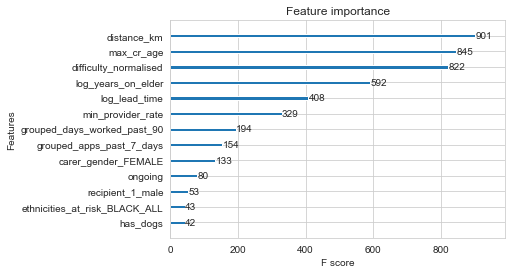

In [82]:
plot_importance(xgb, max_num_features=15)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

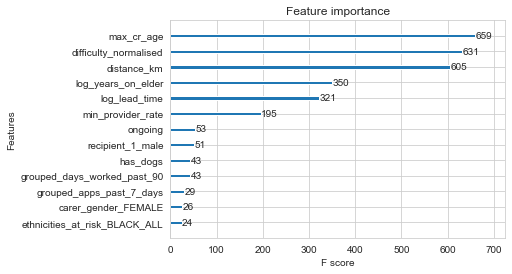

In [23]:
plot_importance(xgb, max_num_features=15)


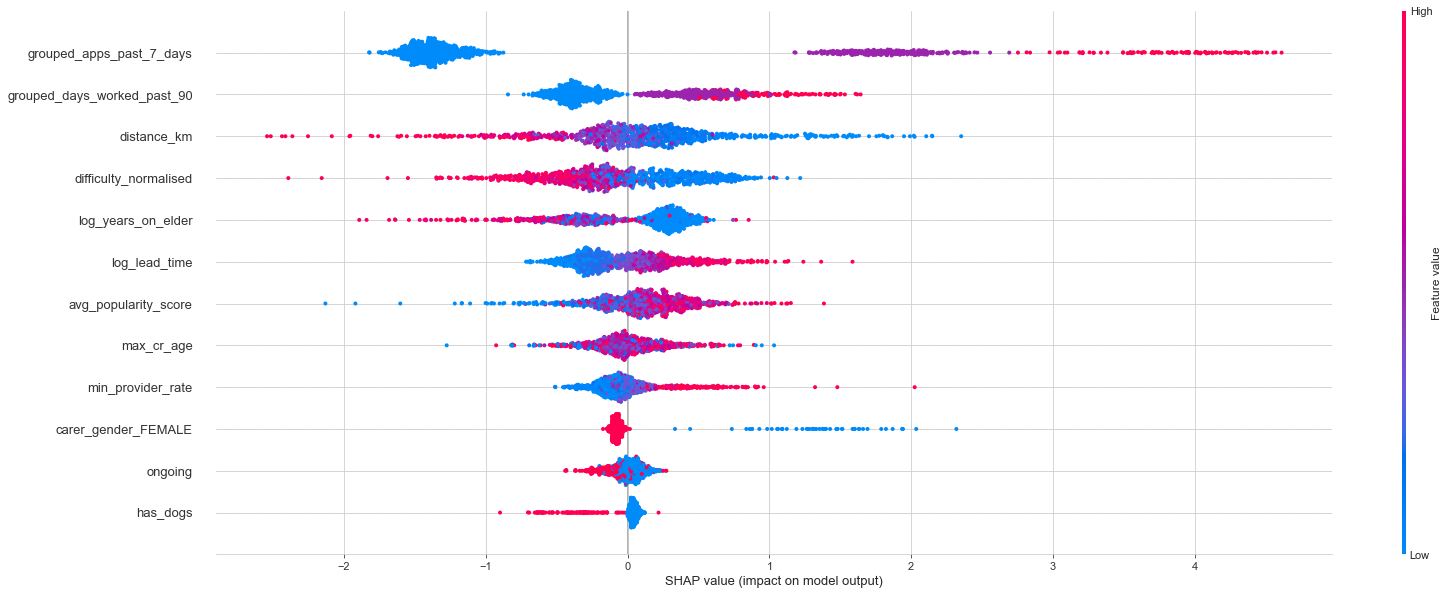

In [224]:
# scaler = StandardScaler()
# scaler.fit(X_train[f_predictors])
# masker = shap.maskers.Impute(data=scaler.transform(X_train[f_predictors]), )

masker = shap.maskers.Impute(data=X_train[f_predictors])

tree_explainer = shap.TreeExplainer(xgb,X_train[f_predictors][:100], masker=masker)
shap_values = tree_explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=12, show=False, plot_size=None )

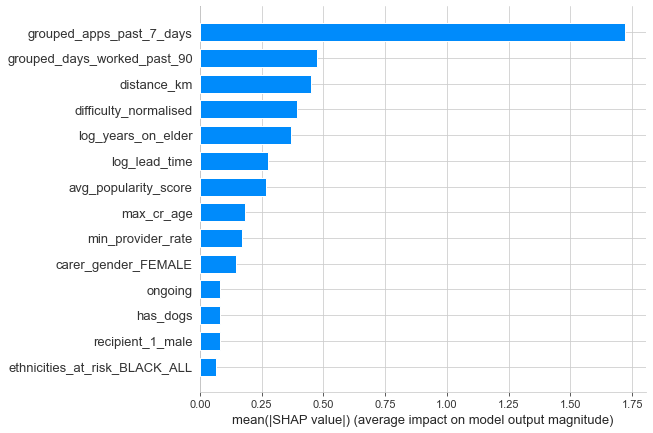

In [225]:
shap.summary_plot(shap_values, features=X_eval[f_predictors][:1000], feature_names=X_eval[f_predictors].columns, plot_type='bar')

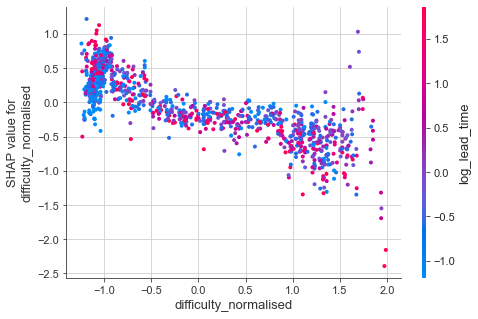

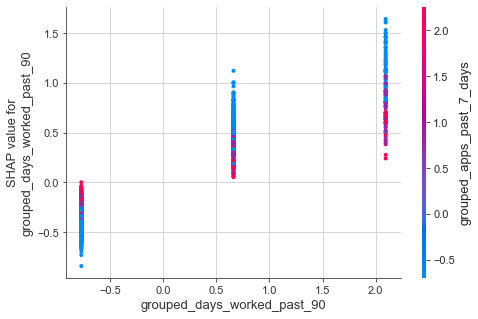

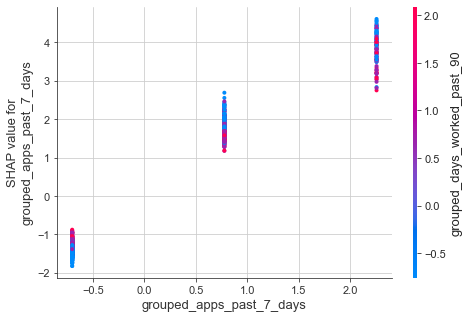

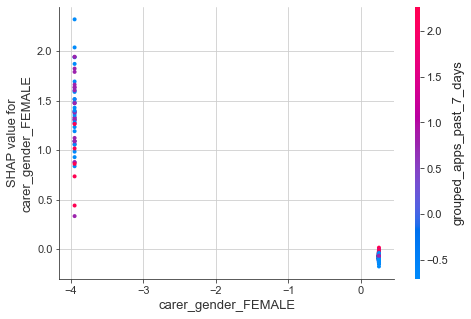

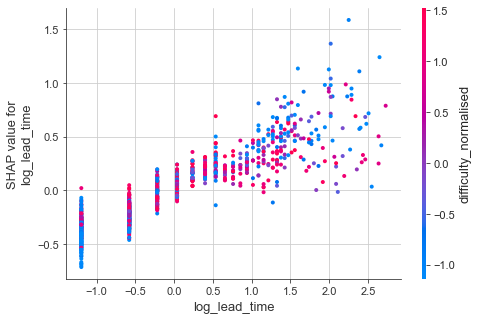

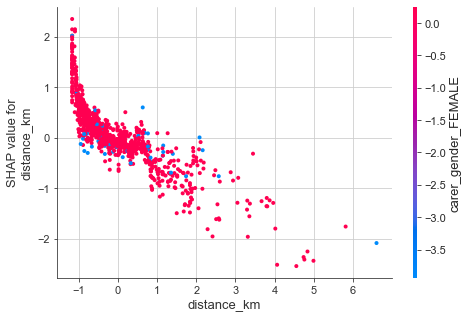

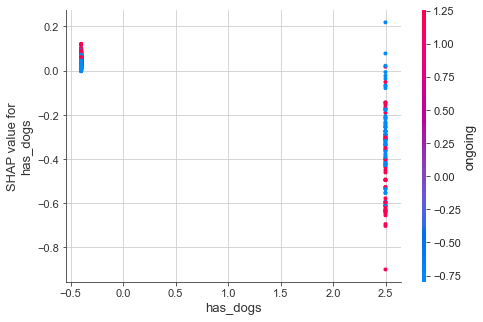

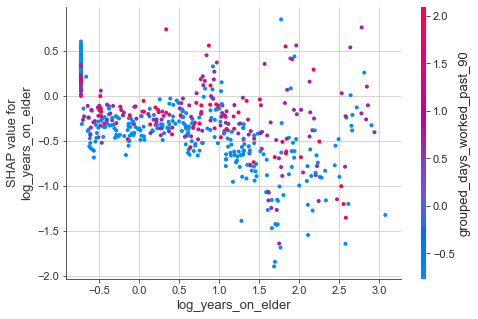

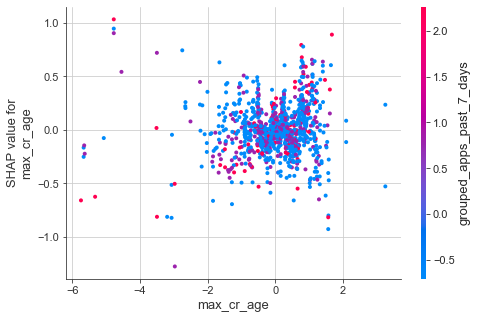

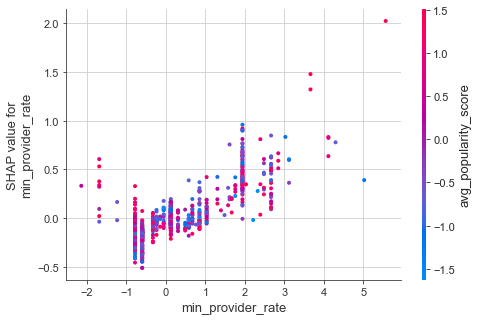

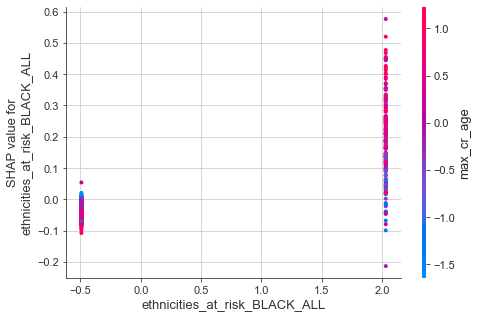

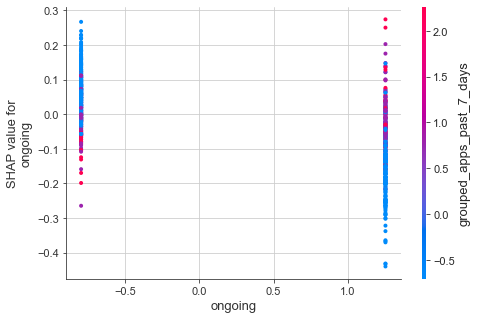

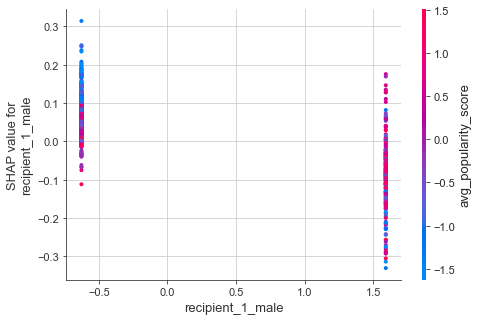

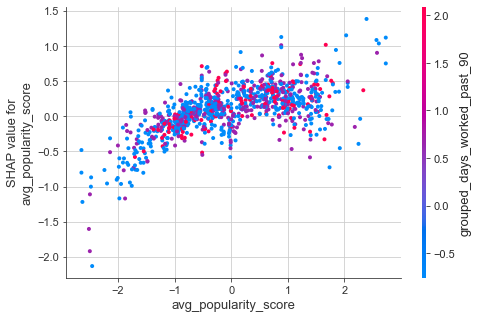

In [226]:
for f in f_predictors:
    shap.dependence_plot(f, shap_values, X_eval[f_predictors][:1000])

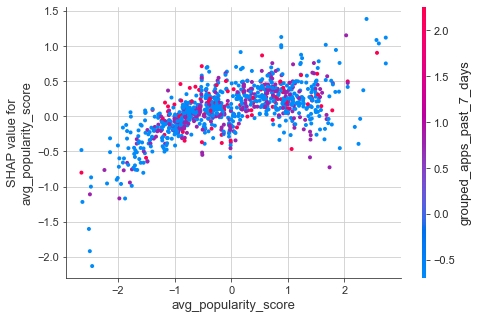

In [229]:
shap.dependence_plot("avg_popularity_score", shap_values, X_eval[f_predictors][:1000], interaction_index="grouped_apps_past_7_days")

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_eval[:1000])
shap.summary_plot(shap_interaction_values, X_eval[:1000], max_display=20)



In [44]:
all_data.groupby(['date_sent_at','placement_ad_id'])['match_request_id'].count().sort_values(ascending=False)[:50]

date_sent_at  placement_ad_id                                                    
2021-08-11    plad_pl_s0maIBLaTt5q_6VKo-4c9b98fd-72ac-490b-b753-295bf55fbdca_nr8B    1178
2021-07-15    plad_pl_s0p3YqleNB0X_nUAK-b2a47ecc-a0d3-465c-83d4-4304f91e95b7_G5IA    1139
2020-12-31    plad_pl_s0o8KMun80r4_IFpl-4ff9179d-123b-4635-98ec-cfc2e7926839_NVgq     983
2020-09-08    plad_pl_s0tPoyU849LK_Ryco-049359c9-7b4d-47a9-ae93-42bbf7335a29_Phcs     970
2021-07-19    plad_pl_s0stD6Izu1ts_ePw8-60d538e4-55a3-41d8-bc00-a7f2379bb3fd_r2JS     897
2021-04-24    plad_pl_s0UlCZZ1jzNw_aeup-0643066d-84ed-480c-b5cd-7a47c265cd90_oBah     884
2021-01-05    plad_pl_s0iSDQjnlJMh_wmlU-5624e560-a960-4662-9292-76364ccc3a92_7jkx     875
2020-12-18    plad_pl_s0LB3R5zhjbY_qvlk-8b435089-2d46-4d47-a2c2-67ff5863b25b_ULNX     865
2020-10-13    plad_pl_s0eHbUjsDcUk_NqtZ-1691f7e8-953e-43e4-9b95-c2780bc257f4_IVxP     836
2021-08-11    plad_pl_s0ur2bhoZcQY_afdq-87a75661-0912-402b-ac61-a2ff48a35e72_WCOs     745
2020-04-13    plad

In [110]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('classifier',XGBClassifier())]
)

#train the model/pipe
scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

#store weights
import pickle
fn = f'../weights/fitted_xgb_{date.today()}.sav'
pickle.dump(xgb, open(fn, 'wb'))

In [112]:
test_dict = {
'plad_pl_s0p3YqleNB0X_nUAK-b2a47ecc-a0d3-465c-83d4-4304f91e95b7_G5IA' : '2021-08-11',
'plad_pl_s0maIBLaTt5q_6VKo-4c9b98fd-72ac-490b-b753-295bf55fbdca_nr8B' : '2021-07-15',
'plad_pl_s0o8KMun80r4_IFpl-4ff9179d-123b-4635-98ec-cfc2e7926839_NVgq' : '2020-12-31',
'plad_pl_s0tPoyU849LK_Ryco-049359c9-7b4d-47a9-ae93-42bbf7335a29_Phcs' : '2020-09-08',
'plad_pl_s0stD6Izu1ts_ePw8-60d538e4-55a3-41d8-bc00-a7f2379bb3fd_r2JS' : '2021-07-19'
}

#loading weights
weights = pickle.load(open(fn, 'rb'))


test_df = all_data.loc[(all_data.placement_ad_id.isin(test_dict.keys()))|(all_data.date_sent_at.isin(test_dict.values()))]

#data preparation

In [113]:
test_df['grouped_days_worked_past_90'] = np.where(test_df['days_worked_past_90'] == 0,0,np.nan)
test_df.loc[(test_df['days_worked_past_90']>0) & (test_df['days_worked_past_90']<=45) ,'grouped_days_worked_past_90'] = 1
test_df.loc[(test_df['days_worked_past_90']>45),'grouped_days_worked_past_90'] = 2

test_df['grouped_apps_past_7_days'] = np.where(test_df['apps_past_7_days'] == 0,0,np.nan)
test_df.loc[(test_df['apps_past_7_days']>0) & (test_df['apps_past_7_days']<8) ,'grouped_apps_past_7_days'] = 1
test_df.loc[(test_df['apps_past_7_days']>7),'grouped_apps_past_7_days'] = 2

test_df = test_df.loc[test_df.lead_time>0]
test_df['log_lead_time'] = np.log(np.where(test_df['lead_time']>0,test_df['lead_time'],0.01))
test_df['log_lead_time'] = test_df.log_lead_time.clip(0)

test_df['apps_past_7_days'].replace(np.nan,0,inplace = True)
test_df['days_worked_past_90'].replace(np.nan,0,inplace = True)


#0.05% conversion
x = scaler.transform(test_df[f_predictors])

test_df = test_df.assign( predicted_value = weights.predict_proba(test_df[f_predictors]))
print(f'TEST Recall is {round(recall_score(np.ravel(test_df.carer_applied_in_8hrs),weights.predict(test_df[f_predictors])),5)}, accuracy is {round(accuracy_score(np.ravel(test_df.carer_applied_in_8hrs),weights.predict(test_df[f_predictors])),5)}, precision is {round(precision_score(np.ravel(test_df.carer_applied_in_8hrs),weights.predict(test_df[f_predictors])),5)}')

#for every placement, top 100 carers and apps from them

#for every carer, number of times they are top 100 (on a given day)

TEST Recall is 0.57447, accuracy is 0.73435, precision is 0.01026


In [131]:
test_df['predicted_value'].value_counts()

0.887286    1169
0.909620     528
0.849062     377
0.804035     353
0.776843     281
            ... 
0.151744       1
0.565088       1
0.394359       1
0.240044       1
0.060753       1
Name: predicted_value, Length: 5914, dtype: int64

In [ ]:
test_df.sort_values(by = 'difficulty_normalised', inplace = True, ascending = False)


In [180]:
test_df['sms_assigned'] = ''
for p in test_df.placement_ad_id.unique()[:10]:
    i = 0
    print(p)
    print(test_df.loc[test_df.placement_ad_id == p]['difficulty_normalised'].values[0])
    carer_ids = test_df.loc[test_df.placement_ad_id == p].sort_values('predicted_value')['carer_id'].values[:100]
    dates = test_df.loc[test_df.placement_ad_id == p]['date_sent_at'].values
    for c in carer_ids:
        if p in (
                test_df.loc[(test_df.sms_assigned != p)&(test_df.carer_id == c
                )&(test_df.date_sent_at.isin(dates))].sort_values('predicted_value')['placement_ad_id'].values[:10]):
            i+=1
            test_df.loc[((test_df.carer_id == c)&(test_df.date_sent_at.isin(dates))),'sms_assigned'] = p
    print(len(test_df.loc[(test_df.sms_assigned == p)&(test_df.carer_id == c
                )&(test_df.date_sent_at.isin(dates))]),i)

plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8a0ee33e28d2_e7K5
1.89886
2 49
plad_pl_s0OXhAUMQrAz_v3xg-b30d09c5-4a1c-4b94-8faa-5f0befa93c2f_aFV3
1.86194
12 70
plad_pl_s0ilAztUeJvL_nN9G-3a524dee-e68e-4ef6-89f8-13823070b391_qLjk
1.81882
4 96
plad_pl_s0ygPBtzT9cX_mUx7-67af18eb-9557-4245-90c2-cb9036949e98_NX62
1.81882
3 49
plad_pl_s0I7c50OqGxg_Vi8Y-92111024-156e-40df-bddb-0caf50407f87_TraK
1.80774
7 50
plad_pl_s0JwdeG4usnA_qDdx-a750c066-9f56-4939-b04a-20aa545fa56e_Y6vO
1.80774
7 100
plad_pl_s0d2TRDBWxGu_YJUn-ace3b9e9-fd38-47af-8d1a-a577446a4e1a_Zqzk
1.79341
19 98
plad_pl_s07wRjTKhcbJ_LFmN-dae99d2e-5b98-4bca-b3ea-dac5f981a0ca_0pIq
1.78706
14 75
plad_pl_s0N6ub6mY7Dn_HLsc-282080ef-560e-4428-aace-1c6ca49a8f00_vNVM
1.78706
9 55
plad_pl_s0fKMup94Wgy_LGhk-32fb68aa-bfe4-4391-b7aa-37de7df4e383_lEJm
1.78706
16 50


In [172]:
test_df.loc[test_df.sms_assigned!=''][['date_sent_at','carer_id','placement_ad_id','sms_assigned','predicted_value']]

,date_sent_at,carer_id,placement_ad_id,sms_assigned,predicted_value
47956,2020-12-31,p154791205,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,0.559613
24056,2020-12-31,p126481834,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,0.364523
36854,2020-12-31,p141416118,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,plad_pl_s0JwdeG4usnA_qDdx-a750c066-9f56-4939-b...,0.559613
184797,2020-12-31,p75235176,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,plad_pl_s07wRjTKhcbJ_LFmN-dae99d2e-5b98-4bca-b...,0.493321
178148,2020-12-31,p66392956,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,0.526790
...,...,...,...,...,...
799648,2020-12-31,p264538033,plad_pl_s0sUupRygpU7_Sgz3-a1aa372a-bb3c-46c4-8...,plad_pl_s0ilAztUeJvL_nN9G-3a524dee-e68e-4ef6-8...,0.501041
558909,2020-12-31,p119848391,plad_pl_s0sUupRygpU7_Sgz3-a1aa372a-bb3c-46c4-8...,plad_pl_s0JwdeG4usnA_qDdx-a750c066-9f56-4939-b...,0.934928
800008,2020-12-31,p264968867,plad_pl_s0sUupRygpU7_Sgz3-a1aa372a-bb3c-46c4-8...,plad_pl_s07wRjTKhcbJ_LFmN-dae99d2e-5b98-4bca-b...,0.877938
613395,2020-12-31,p153604491,plad_pl_s0sUupRygpU7_Sgz3-a1aa372a-bb3c-46c4-8...,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,0.904108


In [175]:
test_df.loc[test_df.sms_assigned!=''][target].mean()*100

0.6944444444444444

In [182]:
test_df.loc[test_df.placement_ad_id =='plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8a0ee33e28d2_e7K5']


,placement_ad_id,match_request_id,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,date_y,texts_past_30_days,date,viewed_placements_past_7_days,predicted_value,difficulty_normalised,grouped_days_worked_past_90,grouped_apps_past_7_days,log_lead_time,sms_assigned
47956,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p154791205,2020-12-31 17:29:09,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,13.0,NaN,NaN,0.559613,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
24056,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p126481834,2020-12-31 17:29:27,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,39.0,NaN,NaN,0.364523,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
36854,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p141416118,2020-12-31 17:29:22,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,96.0,NaN,NaN,0.559613,1.89886,NaN,NaN,2.890372,plad_pl_s0JwdeG4usnA_qDdx-a750c066-9f56-4939-b...
184797,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p75235176,2020-12-31 17:29:30,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,88.0,NaN,NaN,0.493321,1.89886,1.0,NaN,2.890372,plad_pl_s07wRjTKhcbJ_LFmN-dae99d2e-5b98-4bca-b...
178148,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p66392956,2020-12-31 17:29:20,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,30.0,NaN,NaN,0.526790,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
112554,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p229924798,2020-12-31 17:29:21,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,94.0,NaN,NaN,0.546380,1.89886,NaN,NaN,2.890372,plad_pl_s0JwdeG4usnA_qDdx-a750c066-9f56-4939-b...
172130,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p58488977,2020-12-31 17:29:12,2020-12-31 17:20:11,initialPromotionSent,1,18,1,560.0,...,2020-12-31,5.0,NaN,NaN,0.642223,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
116492,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p233916671,2020-12-31 17:29:25,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,24.0,NaN,NaN,0.546380,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
71805,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p182094321,2020-12-31 17:29:30,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,29.0,NaN,NaN,0.268370,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...
76846,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...,pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8e4f-8...,p189028204,2020-12-31 17:29:23,2020-12-31 17:20:11,initialPromotionSent,0,18,1,560.0,...,2020-12-31,31.0,NaN,NaN,0.523835,1.89886,NaN,NaN,2.890372,plad_pl_s0yQ06JKXan8_MCyr-6a18a338-4498-4acd-8...


check feature distributions for population and sample